## Données

### Hardware

In [ ]:
# Montage du drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chargement en local des images (éviter le warm-up effect)
import os

if not os.path.exists("/content/data"):
    print("📁 Copie des fichiers depuis Google Drive...")
    !cp -r "/content/drive/MyDrive/data" "/content/data"
    print("✅ Copie terminée.")
else:
    print("✅ Dossier déjà présent : aucune copie nécessaire.")

✅ Dossier déjà présent : aucune copie nécessaire.


In [ ]:
# Vérification qu'on utilise bien le GPU Google Colab
import tensorflow as tf

print("GPU disponible :", tf.config.list_physical_devices('GPU'))

GPU disponible : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Chargement des données

In [ ]:
# Chargement des labels (sous forme de dataframe)
import pandas as pd

labels = pd.read_csv("/content/drive/MyDrive/labels.csv")
labels.head()

,Unnamed: 0,filename,window,lib,Label
0,0,15b3bab7c186fd35b65df777890c427dd243feacbb85dd...,2003,Die01,Missing
1,1,1856617e1ac2d821a46a41b938818f0169342226a78f93...,2003,Die01,GOOD
2,2,19066cce773b3a092ebf4311b11858aa653da6f8274957...,2003,Die01,Missing
3,3,19c10caf4b24284e1748caed62d94cbb689d6b379b1cf5...,2003,Die01,GOOD
4,4,1a627426d55a668df8bcd381a7fa87b620481995b6755f...,2003,Die01,Missing


In [ ]:
# Train, val, test split
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64  # HP
seed = 42  # HP

# Étape 1 : Split du DataFrame avec stratification
labels_trainval, labels_test = train_test_split(
    labels,
    test_size=0.15,
    stratify=labels["Label"],
    random_state=seed
)

labels_train, labels_val = train_test_split(
    labels_trainval,
    test_size=0.176,  # 0.176 × 85% ≈ 15%
    stratify=labels_trainval["Label"],
    random_state=seed
)

# Étape 2 : Création d’un ImageDataGenerator (pas besoin de validation_split maintenant)
datagen = ImageDataGenerator(rescale=1./255)

# Étape 3 : Créer les datasets avec flow_from_dataframe
train_set = datagen.flow_from_dataframe(
    dataframe=labels_train,
    directory="/content/data",
    x_col="filename",
    y_col="Label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=seed
)

val_set = datagen.flow_from_dataframe(
    dataframe=labels_val,
    directory="/content/data",
    x_col="filename",
    y_col="Label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_set = datagen.flow_from_dataframe(
    dataframe=labels_test,
    directory="/content/data",
    x_col="filename",
    y_col="Label",
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5797 validated image filenames belonging to 6 classes.
Found 1239 validated image filenames belonging to 6 classes.
Found 1242 validated image filenames belonging to 6 classes.


Quelques vérifications

In [ ]:
print(train_set.class_indices)

{'Boucle plate': 0, 'GOOD': 1, 'Lift-off blanc': 2, 'Lift-off noir': 3, 'Missing': 4, 'Short circuit MOS': 5}


In [ ]:
train_set.classes[:10]

[1, 4, 4, 4, 4, 0, 4, 4, 2, 4]

## Modèle

### Chargement du backbone (RESNET50 - ImageNet)

In [ ]:
# Chargement du RESNET50 entraîné sur ImageNet
from tensorflow.keras.applications import ResNet50

resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [ ]:
# Freeze des layers du RN50

for layer in resnet50.layers:
    layer.trainable = False

Quelques vérifications

In [ ]:
resnet50.layers[:10]

[<InputLayer name=input_layer, built=True>,
 <ZeroPadding2D name=conv1_pad, built=True>,
 <Conv2D name=conv1_conv, built=True>,
 <BatchNormalization name=conv1_bn, built=True>,
 <Activation name=conv1_relu, built=True>,
 <ZeroPadding2D name=pool1_pad, built=True>,
 <MaxPooling2D name=pool1_pool, built=True>,
 <Conv2D name=conv2_block1_1_conv, built=True>,
 <BatchNormalization name=conv2_block1_1_bn, built=True>,
 <Activation name=conv2_block1_1_relu, built=True>]

In [ ]:
resnet50.output

<KerasTensor shape=(None, 7, 7, 2048), dtype=float32, sparse=False, name=keras_tensor_174>

### Fine-tuning - définition

In [ ]:
# Contruction du modèle
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

n_neurons = 256  # HP

x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(n_neurons, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Entraînement

In [ ]:
# Définition d'une métrique F1 appelée en callback (suivi entraînement)

from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import numpy as np

class F1ScoreCallback(Callback):
    def __init__(self, val_generator):
        super().__init__()
        self.val_generator = val_generator
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        f1 = f1_score(y_true, y_pred_classes, average='macro')  # ou 'weighted', 'micro'
        self.f1_scores.append(f1)
        print(f"\n Epoch {epoch+1} F1-score (macro): {f1:.4f}")
        if logs is not None:
            logs['val_f1'] = f1

f1_score_callback = F1ScoreCallback(val_set)

In [ ]:
# Compilation du modèle (optmizer + loss function + metrics)
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001  # HP

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
# Définition d'un early stopping
from tensorflow.keras.callbacks import EarlyStopping

patience = 10  # HP

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)

In [ ]:
# Définition d'un checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "/content/drive/MyDrive/model/trial_001.h5"

checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

In [ ]:
# Réduction du learning rate dans les zones de plateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

plateau_patience = 3  # HP
plateau_factor = 0.5  # HP

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=plateau_factor,
    patience=plateau_patience,
    verbose=1
)

In [ ]:
# Calcul des poids de rebalancing (à passer dans model.fit(...))

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_set.classes),
    y=train_set.classes
)

class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: np.float64(19.717687074829932),
 1: np.float64(1.116955684007707),
 2: np.float64(5.0850877192982455),
 3: np.float64(13.235159817351597),
 4: np.float64(0.21318770226537218),
 5: np.float64(10.979166666666666)}

In [ ]:
# Entraînement
epochs = 30  # HP

history = model.fit(
    train_set,
    epochs=epochs,
    validation_data=val_set,
    callbacks=[early_stopping, checkpoint, reduce_lr, f1_score_callback],
    class_weight=class_weights_dict,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.2101 - loss: 1.9387 - precision: 0.0748 - recall: 0.0016

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 412ms/step

 Epoch 1 F1-score (macro): 0.2220
91/91 ━━━━━━━━━━━━━━━━━━━━ 86s 658ms/step - accuracy: 0.2119 - loss: 1.9370 - precision: 0.0814 - recall: 0.0017 - val_accuracy: 0.4931 - val_loss: 1.5355 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010 - val_f1: 0.2220
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4376 - loss: 1.6111 - precision: 0.7094 - recall: 0.0713

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step

 Epoch 2 F1-score (macro): 0.2128
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 306ms/step - accuracy: 0.4387 - loss: 1.6108 - precision: 0.7110 - recall: 0.0721 - val_accuracy: 0.5763 - val_loss: 1.4055 - val_precision: 0.9951 - val_recall: 0.1646 - learning_rate: 0.0010 - val_f1: 0.2128
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.5564 - loss: 1.4812 - precision: 0.8122 - recall: 0.1878

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step

 Epoch 3 F1-score (macro): 0.2717
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 301ms/step - accuracy: 0.5567 - loss: 1.4809 - precision: 0.8132 - recall: 0.1884 - val_accuracy: 0.7191 - val_loss: 1.0150 - val_precision: 0.9946 - val_recall: 0.4455 - learning_rate: 0.0010 - val_f1: 0.2717
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6208 - loss: 1.4289 - precision: 0.8334 - recall: 0.3558

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step

 Epoch 4 F1-score (macro): 0.3390
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 295ms/step - accuracy: 0.6205 - loss: 1.4292 - precision: 0.8329 - recall: 0.3555 - val_accuracy: 0.7127 - val_loss: 0.8899 - val_precision: 0.9635 - val_recall: 0.4681 - learning_rate: 0.0010 - val_f1: 0.3390
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step

 Epoch 5 F1-score (macro): 0.3513
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - accuracy: 0.6128 - loss: 1.3663 - precision: 0.8788 - recall: 0.4085 - val_accuracy: 0.7022 - val_loss: 0.9253 - val_precision: 0.8865 - val_recall: 0.4600 - learning_rate: 0.0010 - val_f1: 0.3513
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step

 Epoch 6 F1-score (macro): 0.2282
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - accuracy: 0.6208 - loss: 1.3660 - precision: 0.8549 - recall: 0.4250 - val_accuracy: 0.6037 - val_loss: 1.0601 - val_precision: 0.7221 - val_recall: 0.4068 - learning_rate: 0.0010 - val_f1: 0.2282
Epoch 7/30
91/91 ━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step

 Epoch 8 F1-score (macro): 0.3988
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 298ms/step - accuracy: 0.6164 - loss: 1.2798 - precision: 0.8490 - recall: 0.4550 - val_accuracy: 0.6618 - val_loss: 0.8293 - val_precision: 0.9523 - val_recall: 0.4673 - learning_rate: 5.0000e-04 - val_f1: 0.3988
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step

 Epoch 9 F1-score (macro): 0.3965
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.6233 - loss: 1.1967 - precision: 0.8320 - recall: 0.4560 - val_accuracy: 0.6602 - val_loss: 0.8613 - val_precision: 0.8652 - val_recall: 0.4713 - learning_rate: 5.0000e-04 - val_f1: 0.3965
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step

 Epoch 10 F1-score (macro): 0.3433
91/91 ━━━━━━━━━━━━━━━━━━━━ 25s 273ms/step - accuracy: 0.6702 - loss: 1.1302 - precision: 0.9119 - recall: 0.4819 - val_accuracy: 0.6287 - val_loss: 0.9343 - val_precision: 0.7497 - val_recall: 0.4520 - learning_rate: 5.0000e-04 - val_f1: 0.3433
Epoch 11/30
9

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step

 Epoch 14 F1-score (macro): 0.4389
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 301ms/step - accuracy: 0.6588 - loss: 1.0420 - precision: 0.8742 - recall: 0.4924 - val_accuracy: 0.7143 - val_loss: 0.8225 - val_precision: 0.8046 - val_recall: 0.4818 - learning_rate: 2.5000e-04 - val_f1: 0.4389
Epoch 15/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step

 Epoch 15 F1-score (macro): 0.4152
91/91 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.6610 - loss: 0.9946 - precision: 0.7984 - recall: 0.4894 - val_accuracy: 0.6441 - val_loss: 0.8570 - val_precision: 0.8943 - val_recall: 0.4915 - learning_rate: 2.5000e-04 - val_f1: 0.4152
Epoch 16/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step

 Epoch 16 F1-score (macro): 0.3888
91/91 ━━━━━━━━━━━━━━━━━━━━ 24s 266ms/step - accuracy: 0.6821 - loss: 1.0069 - precision: 0.9216 - recall: 0.5179 - val_accuracy: 0.6885 - val_loss: 0.8875 - val_precision: 0.7866 - val_recall: 0.4641 - learning_rate: 2.5000e-04 - val_f1: 0.3888
Epoch 17/3

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step

 Epoch 17 F1-score (macro): 0.3935
91/91 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - accuracy: 0.6781 - loss: 1.0304 - precision: 0.8347 - recall: 0.5187 - val_accuracy: 0.6949 - val_loss: 0.8179 - val_precision: 0.7832 - val_recall: 0.4899 - learning_rate: 2.5000e-04 - val_f1: 0.3935
Epoch 18/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step

 Epoch 18 F1-score (macro): 0.4279
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - accuracy: 0.6692 - loss: 1.0718 - precision: 0.8547 - recall: 0.4979 - val_accuracy: 0.6521 - val_loss: 0.8429 - val_precision: 0.7788 - val_recall: 0.5343 - learning_rate: 2.5000e-04 - val_f1: 0.4279
Epoch 19/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step

 Epoch 19 F1-score (macro): 0.3930
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.6666 - loss: 1.0521 - precision: 0.7871 - recall: 0.5017 - val_accuracy: 0.5722 - val_loss: 1.1112 - val_precision: 0.7369 - val_recall: 0.4544 - learning_rate: 2.5000e-04 - val_f1: 0.3930
Epoch 20/3

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step

 Epoch 22 F1-score (macro): 0.4439
91/91 ━━━━━━━━━━━━━━━━━━━━ 28s 308ms/step - accuracy: 0.6390 - loss: 0.9957 - precision: 0.8415 - recall: 0.5100 - val_accuracy: 0.6764 - val_loss: 0.8083 - val_precision: 0.8111 - val_recall: 0.5408 - learning_rate: 1.2500e-04 - val_f1: 0.4439
Epoch 23/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step

 Epoch 23 F1-score (macro): 0.4203
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 284ms/step - accuracy: 0.6752 - loss: 1.0389 - precision: 0.8236 - recall: 0.5293 - val_accuracy: 0.6449 - val_loss: 0.8959 - val_precision: 0.7909 - val_recall: 0.5069 - learning_rate: 1.2500e-04 - val_f1: 0.4203
Epoch 24/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step

 Epoch 24 F1-score (macro): 0.4214
91/91 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.6519 - loss: 1.0761 - precision: 0.8057 - recall: 0.5128 - val_accuracy: 0.6505 - val_loss: 0.8549 - val_precision: 0.8023 - val_recall: 0.5174 - learning_rate: 1.2500e-04 - val_f1: 0.4214
Epoch 25/3

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step

 Epoch 26 F1-score (macro): 0.4563
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 291ms/step - accuracy: 0.6741 - loss: 1.0824 - precision: 0.8060 - recall: 0.5178 - val_accuracy: 0.7022 - val_loss: 0.7675 - val_precision: 0.8248 - val_recall: 0.5359 - learning_rate: 6.2500e-05 - val_f1: 0.4563
Epoch 27/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step

 Epoch 27 F1-score (macro): 0.4290
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 279ms/step - accuracy: 0.6797 - loss: 0.9709 - precision: 0.8019 - recall: 0.5285 - val_accuracy: 0.6497 - val_loss: 0.8248 - val_precision: 0.7909 - val_recall: 0.5311 - learning_rate: 6.2500e-05 - val_f1: 0.4290
Epoch 28/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step

 Epoch 28 F1-score (macro): 0.4128
91/91 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.6895 - loss: 0.9743 - precision: 0.8021 - recall: 0.5373 - val_accuracy: 0.6174 - val_loss: 0.8908 - val_precision: 0.8042 - val_recall: 0.5238 - learning_rate: 6.2500e-05 - val_f1: 0.4128
Epoch 29/3

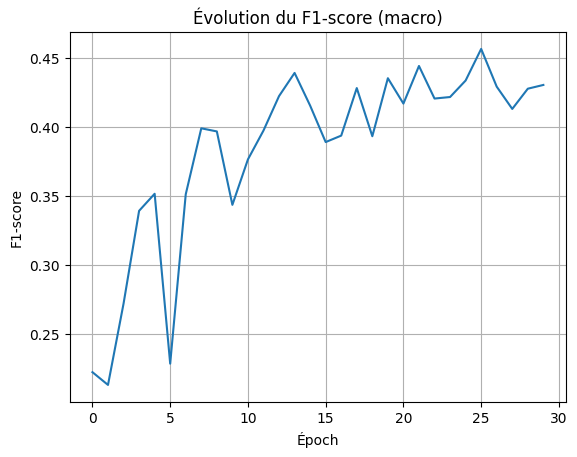

In [ ]:
# Tracé du F1 score (val_set)

import matplotlib.pyplot as plt

plt.plot(f1_score_callback.f1_scores)
plt.title("Évolution du F1-score (macro)")
plt.xlabel("Époch")
plt.ylabel("F1-score")
plt.grid(True)
plt.show()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate', 'val_f1'])


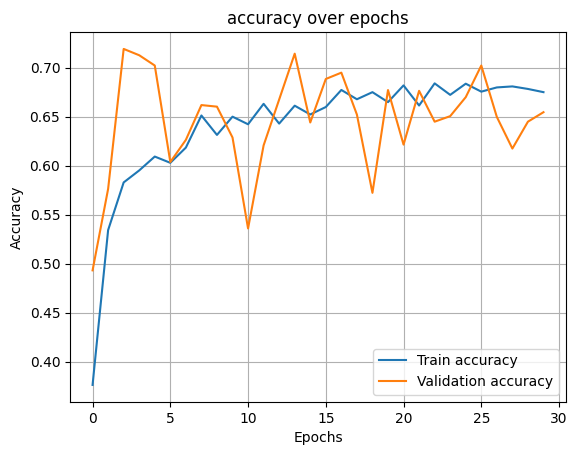

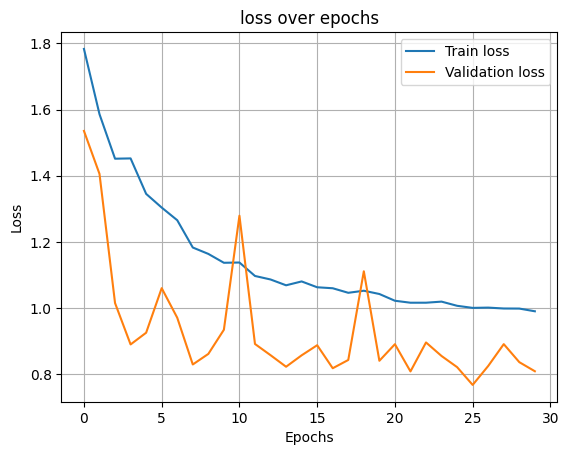

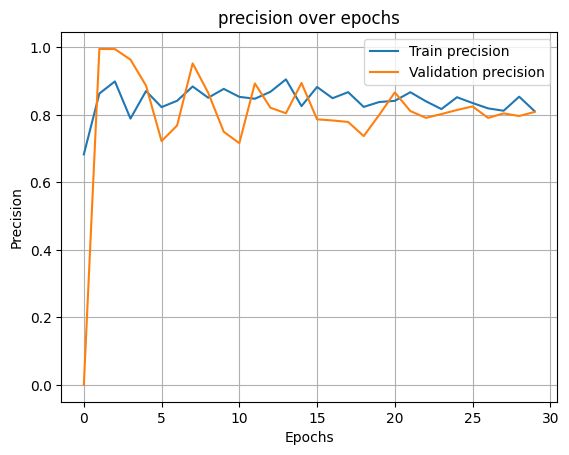

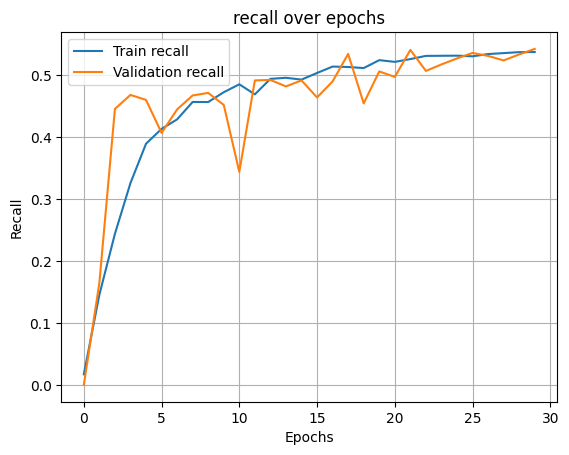

In [ ]:
import matplotlib.pyplot as plt

# Supposons que tu as entraîné ton modèle avec :
# history = model.fit(...)

# Pour voir ce que tu peux tracer :
print(history.history.keys())

# Exemple de courbes :
def plot_learning_curves(history):
    keys = history.history.keys()
    metrics = [m for m in keys if not m.startswith('val_') and f'val_{m}' in keys]

    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric} over epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

# Appel de la fonction
plot_learning_curves(history)


## Test

In [ ]:
# Performances générales
results = model.evaluate(test_set)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 410ms/step - accuracy: 0.7315 - loss: 0.7184 - precision: 0.8432 - recall: 0.5508
loss: 0.7295
compile_metrics: 0.7303


In [ ]:
# Rapport détaillé
from sklearn.metrics import classification_report, confusion_matrix

# Récupérer toutes les prédictions
y_pred_probs = model.predict(test_set, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Obtenir les vraies étiquettes
y_true = test_set.classes  # Attention : ce sont des entiers
class_names = list(test_set.class_indices.keys())  # noms des classes dans l’ordre

print(classification_report(y_true, y_pred, target_names=class_names))

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 422ms/step
                   precision    recall  f1-score   support

     Boucle plate       0.05      0.73      0.09        11
             GOOD       0.63      0.68      0.66       185
   Lift-off blanc       0.67      0.25      0.36        40
    Lift-off noir       0.14      0.88      0.24        16
          Missing       0.98      0.76      0.86       971
Short circuit MOS       0.81      0.68      0.74        19

         accuracy                           0.73      1242
        macro avg       0.55      0.66      0.49      1242
     weighted avg       0.90      0.73      0.79      1242



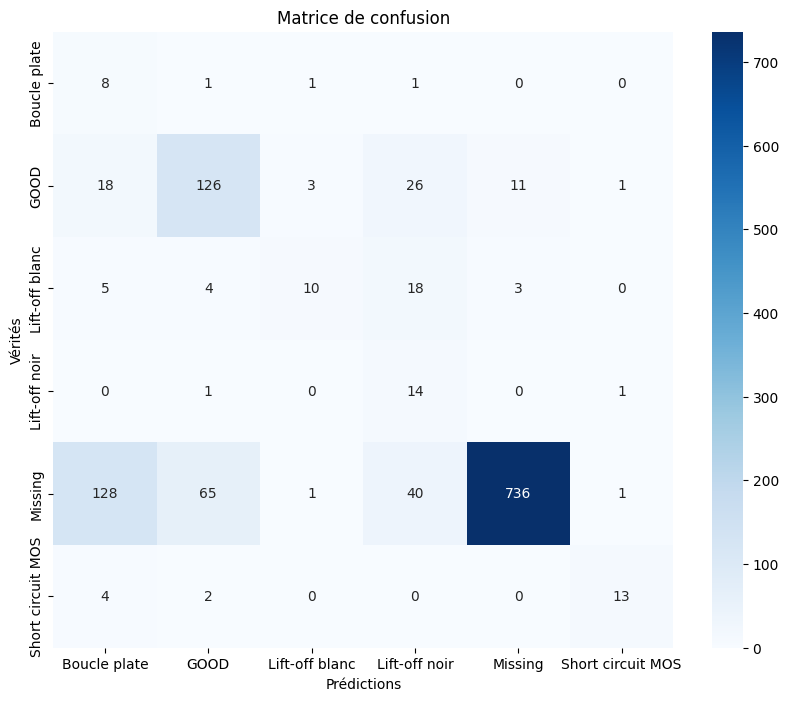

In [ ]:
# Matrice de confusion
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion")
plt.show()